# Determinant analysis

Go to [Index](response_Witz2019_index.ipynb).

In this notebook we perform the "determinant analysis" on 4 experimental datasets from Witz et al (2019) and 6 experimental datasets from Si & Le Treut (2019).

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Imports

In [2]:
import os, copy, pickle, itertools, tabulate
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'   # to export text as text, not curves
from IPython.display import Image

import sys
sys.path.append('code')
from functions_response import add_allvariables, compute_determinant, plot_Ivalues_main_models, plot_Ivalues, plot_Ivalues_all, plot_Ivalues_all_overlay, load_table, process_gw

## Parameters

In [3]:
label_mapping = { \
                'lambda': "$\lambda$", \
                'Sb': "$S_b$",\
                'Sd': "$S_d$",\
                'tau': "$\\tau$",\
                'tau_cyc': "$\\tau_{cyc}$" , \
                'Si': "$S_i$" , \
                'Delta_bd': "$\Delta_{d}$", \
                'Delta_bi': "$\Delta_{bi}$", \
                'R_bd': "$R_{bd}$", \
                'R_bi': "$R_{bi}$", \
                'Lambda_i_b': "$\Lambda_i^{(b)}$", \
                'Lambda_i': "$\Lambda_i$", \
                'Lambda_i_f': "$\Lambda_i^{(f)}$", \
                'tau_ii_b': "$\\tau_{ii}^{(f)}$", \
                'tau_ii': "$\\tau_{ii}$", \
                'delta_id': "$\delta_{id}$", \
                'delta_ii_backward': "$\delta_{ii}^{(b)}$", \
                'delta_ii': "$\delta_{ii}$", \
                'R_ii_b': "$R_{ii}^{(b)}$", \
                'R_ii': "$R_{ii}$", \
                'R_id': "$R_{id}$"
                }
nval = 50  # number of values to report in the plot
ext_list = ['.png','.svg']

variables = ['lambda', 'Sb', 'Sd', 'tau', 'tau_cyc', 'Delta_bd', 'Si', 'Delta_bi', 'R_bd', 'R_bi', \
             'Lambda_i', 'Lambda_i_b', 'Lambda_i_f', 'tau_ii', 'delta_ii', 'delta_id', 'R_ii', 'R_id']

direxp = os.path.join('.','experiments')
names_all = []


## List possible combinations

In [4]:
combinations = []
nvar = 3

for comb in itertools.combinations(variables, nvar):
    combinations.append(comb)

## Perform determinant analysis on experimental data from Si & Le Treut (2019)

In [5]:
names = ['mg1655_acetate', \
         'mg1655_glucose', \
         'mg1655_glycerol11aa', \
         'ncm3722_arginine', \
         'ncm3722_glucose', \
         'ncm3722_glucose12aa' \
        ]

In [6]:
for name in names:
    fpath = os.path.join(direxp,name,'colidata.pkl')
    print(name, fpath)
    if not name in names_all:
        names_all.append(name)
    outputdir = os.path.join(direxp,name)
#     print(fpath)
    
    colidata = pd.read_pickle(fpath)
    add_allvariables(colidata)
    
    # rename some variables
    col_mapping = { \
                'initiator B': 'tau_bi', \
                'tau_ii_f': 'tau_ii', \
                'R_ii_f': 'R_ii'
                }
    
    colidata.rename(columns=col_mapping, inplace=True)

    colidata['lambda'] = colidata['lambda']*60
    ncells = len(colidata)
    print("ncells = {:d}".format(ncells))
    
    
    ncells = len(colidata['Lambda_i'].dropna())
    print("ncells (initiation picked) = {:d}".format(ncells))

    ncells = len(colidata.dropna())
    print("ncells (full information) = {:d}".format(ncells))
    
    # determinant analysis
    table = []
    for comb in combinations:
        data = colidata.loc[:,list(comb)].dropna().to_numpy().astype('float64').T
        I = compute_determinant(data)
    #     print(count,comb,"I = {:.4f}".format(I))
        table += [list(comb) + [I] + [data.shape[1]]]

    table.sort(key=lambda x: x[3], reverse=True)
    headers=['var {:d}'.format(i+1) for i in range(nvar)]+['I']+['npts']

    fname = 'determinant_analysis'
    fpath = os.path.join(outputdir,fname + '.txt')

    with open(fpath,'w') as fout:
        fout.write(tabulate.tabulate(table, tablefmt='plain', headers=headers))
    

mg1655_acetate ./experiments/mg1655_acetate/colidata.pkl
ncells = 1554
ncells (initiation picked) = 1554
ncells (full information) = 519
mg1655_glucose ./experiments/mg1655_glucose/colidata.pkl
ncells = 1807
ncells (initiation picked) = 1807
ncells (full information) = 1283
mg1655_glycerol11aa ./experiments/mg1655_glycerol11aa/colidata.pkl
ncells = 1491
ncells (initiation picked) = 1491
ncells (full information) = 596
ncm3722_arginine ./experiments/ncm3722_arginine/colidata.pkl
ncells = 1701
ncells (initiation picked) = 1701
ncells (full information) = 920
ncm3722_glucose ./experiments/ncm3722_glucose/colidata.pkl
ncells = 1432
ncells (initiation picked) = 1432
ncells (full information) = 650
ncm3722_glucose12aa ./experiments/ncm3722_glucose12aa/colidata.pkl
ncells = 1464
ncells (initiation picked) = 1464
ncells (full information) = 203


## Perform determinant analysis on experimental data from Witz et al (2019)

In [7]:
# parameters
mapping_dict = {'glycerol': { \
                             'dir': '20180706_GW296_glycerol37_1_MMStack', \
                             'period': 0 \
                            }, 
                'glucose': { \
                           'dir': '20180711_GW296_glucose37_1_MMStack', \
                            'period': 0 \
                           },
                'glucose8a': { \
                               'dir': '20180709_GW296_glucose8aa37_1_MMStack', \
                               'period': 0 \
                              },
                'glycerolauto': { \
                                'dir': '20170327_GW339_temp', \
                                 'period': 1
                                }
            }
# period from `dataset_fig_5AB.ipynb' notebook
size_columns = ['length', 'Lb', 'Lb_fit', 'Ld_fit', 'Ld', 'Li', 'Li_fit', 'DLi', 'Li_old']
size_scale = 0.065 # nm/px
time_scale = 3 # min / frame
fitting = False

# data exported by Witz et al.
fpath=os.path.join('..','Data_export','Fig1_2_3.csv')
df_export = pd.read_csv(fpath)
names_export = df_export['condition'].unique().tolist()
match_export = False   # set True to match exported_data in following analysis
dec = 4               # decimals when rounding up lambda_inv for mapping
if (match_export):
    fitting=True

In [8]:
# load files
names = list(mapping_dict.keys())
# names=['glucose8a']
for name in names:
    fpath = os.path.join('..','PreProcessed', mapping_dict[name]['dir'], 'colidata.pkl')
    print(name, fpath)
    if not name in names_all:
        names_all.append(name)
    colidata = pd.read_pickle(fpath)

    outputdir = os.path.join(direxp, name)
    if not os.path.isdir(outputdir):
        os.makedirs(outputdir)

    # rescale size
    func = lambda x: x*size_scale
    colidata[size_columns] = colidata[size_columns].apply(func)
    
    # remove cells without enough data points
    func = lambda x:  len(x) < 2
    idx = colidata['length'].apply(func)
    colidata.drop(colidata.index[idx], axis=0, inplace=True)
    
    # process data
    process_gw(colidata, time_scale, fitting)
    
    # save this dataframe
    fpath = os.path.join(outputdir,'colidata.pkl')
    colidata.to_pickle(fpath)
    print(fpath)
    
    # add variables
    add_allvariables(colidata, gw=True)

    # rename some variables
    col_mapping = { \
                'initiator B': 'tau_bi', \
                'tau_ii_f': 'tau_ii', \
                'R_ii_f': 'R_ii'
                }
    colidata.rename(columns=col_mapping, inplace=True)

    # rescale growth rate
    colidata['lambda'] = colidata['lambda']*60

    # filter data
    ncells = len(colidata)
    print("ncells (pre-filter) = {:d}".format(ncells))
    
    ## period
    period = mapping_dict[name]['period']
    idx = colidata['period'] == period
    colidata = colidata.loc[idx]
    
    ## with reference data set
    if match_export and (name in names_export):
        df_ref = df_export.loc[df_export['condition'] == name]
        set_ref = set(df_ref['lambda_inv'].dropna().round(dec).unique().tolist())
        set_data = set(colidata['tau_eff'].dropna().round(dec).unique().tolist())
        selection = list(set_data.intersection(set_ref))
        idx = colidata['tau_eff'].round(dec).isin(selection)
        colidata.drop(colidata.index[~idx], axis=0, inplace=True)
        
    ncells = len(colidata)
    print("ncells (post-filter) = {:d}".format(ncells))

    ncells = len(colidata['Lambda_i'].dropna())
    print("ncells (initiation picked) = {:d}".format(ncells))

    ncells = len(colidata.dropna())
    print("ncells (full information) = {:d}".format(ncells))


#     idx = colidata.dropna().index
    # determinant analysis
    table = []
    for comb in combinations:
        data = colidata.loc[:,list(comb)].dropna().to_numpy().astype('float64').T
        I = compute_determinant(data)
    #     print(count,comb,"I = {:.4f}".format(I))
        table += [list(comb) + [I] + [data.shape[1]]]

    table.sort(key=lambda x: x[3], reverse=True)
    headers=['var {:d}'.format(i+1) for i in range(nvar)]+['I']+['npts']

    fname = 'determinant_analysis'
    fpath = os.path.join(outputdir,fname + '.txt')

    with open(fpath,'w') as fout:
        fout.write(tabulate.tabulate(table, tablefmt='plain', headers=headers))

glycerol ../PreProcessed/20180706_GW296_glycerol37_1_MMStack/colidata.pkl
./experiments/glycerol/colidata.pkl
ncells (pre-filter) = 865
ncells (post-filter) = 865
ncells (initiation picked) = 811
ncells (full information) = 395
glucose ../PreProcessed/20180711_GW296_glucose37_1_MMStack/colidata.pkl
./experiments/glucose/colidata.pkl
ncells (pre-filter) = 1094
ncells (post-filter) = 1094
ncells (initiation picked) = 994
ncells (full information) = 479
glucose8a ../PreProcessed/20180709_GW296_glucose8aa37_1_MMStack/colidata.pkl
./experiments/glucose8a/colidata.pkl
ncells (pre-filter) = 1251
ncells (post-filter) = 1251
ncells (initiation picked) = 1118
ncells (full information) = 568
glycerolauto ../PreProcessed/20170327_GW339_temp/colidata.pkl
./experiments/glycerolauto/colidata.pkl
ncells (pre-filter) = 3611
ncells (post-filter) = 3018
ncells (initiation picked) = 2548
ncells (full information) = 862


## Main models

In [9]:
# the 3 special combinations
special_combs = {\
                 'GW': ['lambda', 'delta_ii', 'delta_id'], \
                 'SLT': ['lambda', 'Delta_bd', 'delta_ii'], \
                 'HC': ['lambda', 'tau_cyc', 'Lambda_i'] \
                }
special_combs_keys = list(special_combs.keys())
special_colors = ['darkblue', 'yellow', 'darkred', 'darkgreen']

In [10]:
results = []
for name in names_all:
# for name in names:
    print('-'*10)
    print(name)
    
    fname = 'determinant_analysis'
    
    fpath = os.path.join(direxp,name,fname + '.txt')
    table = load_table(fpath)

    res = [name]
    for key in special_combs_keys:
        myvars = set(special_combs[key])
        for line in table:
            thisvars = set(line[:3])
            I = float(line[3])
            npts = int(line[4])
            if myvars == thisvars:
                print("{:<20s}I = {:.6f}  (npts = {:d})".format(key,I,npts))
                res.append(I)
                break
        # end reading the table
    # end checking special combinations
    results.append(res)

----------
mg1655_acetate
GW                  I = 0.924268  (npts = 1074)
SLT                 I = 0.829172  (npts = 1074)
HC                  I = 0.417602  (npts = 1554)
----------
mg1655_glucose
GW                  I = 0.875542  (npts = 1640)
SLT                 I = 0.833507  (npts = 1640)
HC                  I = 0.471560  (npts = 1807)
----------
mg1655_glycerol11aa
GW                  I = 0.812516  (npts = 1233)
SLT                 I = 0.713263  (npts = 1233)
HC                  I = 0.497346  (npts = 1491)
----------
ncm3722_arginine
GW                  I = 0.807433  (npts = 1247)
SLT                 I = 0.934928  (npts = 1247)
HC                  I = 0.671608  (npts = 1701)
----------
ncm3722_glucose
GW                  I = 0.939279  (npts = 1107)
SLT                 I = 0.973360  (npts = 1107)
HC                  I = 0.738780  (npts = 1432)
----------
ncm3722_glucose12aa
GW                  I = 0.927092  (npts = 1088)
SLT                 I = 0.952118  (npts = 1088)
HC             

In [11]:
headers=['condition'] + special_combs_keys

fname = 'main_models'
fpath = os.path.join(direxp,fname + '.txt')

with open(fpath,'w') as fout:
    fout.write(tabulate.tabulate(results, tablefmt='plain', headers=headers))

In [12]:
# plot the main models scores
fname = 'main_models'
fpath = os.path.join(direxp,fname + '.txt')
table = load_table(fpath, skiprows=0)
special_colors = ['darkblue', 'darkred', 'darkgreen']

fig = plot_Ivalues_main_models(table, figsize=(6,4), colors=special_colors)

fname = 'main_models'
fpath = os.path.join(direxp,fname)
for ext in ext_list:
    fig.savefig(fpath+ext, dpi=300, bbox_inches='tight', pad_inches=0)
    print("Saved figure in {:s}".format(fpath+ext))
#     fig.clf()
plt.close('all')

code/functions_response.py:1932: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:1933: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Saved figure in ./experiments/main_models.png
Saved figure in ./experiments/main_models.svg


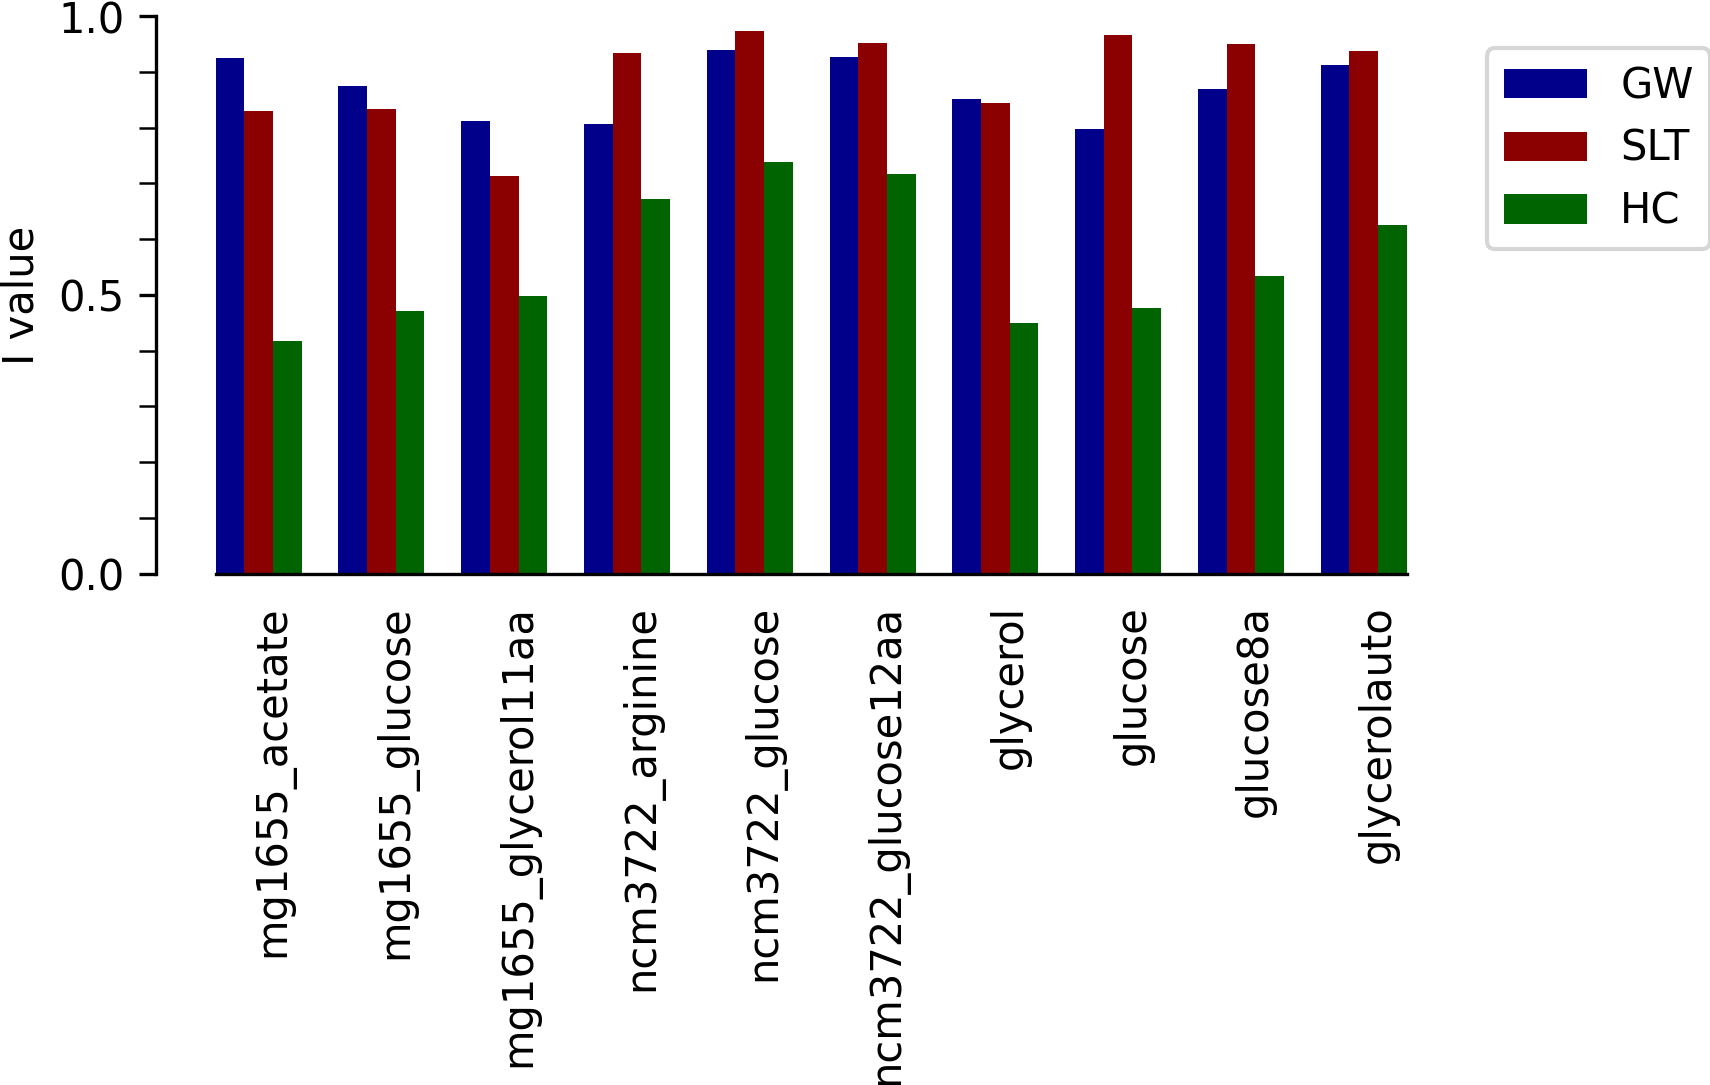

In [13]:
fname = 'main_models'
fpath = os.path.join(direxp,fname) + '.png'
# display one of the previous figures
Image(filename=fpath) 

### Make plots

In [14]:
# the 3 special combinations
special_combs = {\
                 'GW': ['lambda', 'delta_ii', 'delta_id'], \
                 'HC': ['lambda', 'tau_cyc', 'Lambda_i'], \
                 'SLT': ['lambda', 'Delta_bd', 'delta_ii'], \
                }
special_colors = ['darkblue', 'darkred', 'darkgreen']

In [15]:
tables = []
specials = [comb for comb in special_combs.values()]
for name in names_all:
    print('-'*10)
    print(name)
    
    # load data
    fname = 'determinant_analysis'
    fpath = os.path.join(direxp,name,fname + '.txt')
    table = load_table(fpath)
    tables.append(table)
    
    # make figure
    ## first figure
    fname = "determinant_analysis_top{:d}".format(nval)
    fpath = os.path.join(direxp,name,fname)
    figname = name
    fig = plot_Ivalues(table, label_mapping, fig_title=figname, nval=nval, figsize=(3,12), fmt_str='{:.4f}', specials=specials, special_colors=special_colors)
    
    for ext in ext_list:
        fig.savefig(fpath+ext, dpi=300, bbox_inches='tight', pad_inches=0)
        print("Saved figure in {:s}".format(fpath+ext))
#     fig.clf()
    plt.close('all')
    


    ## second figure
    fname = "determinant_analysis_all"
    fpath = os.path.join(direxp,name,fname)
    figname = name

    fig = plot_Ivalues_all(table, fig_title=figname, figsize=(12,3), fmt_str='{:.4f}', specials=specials, special_colors=special_colors)
    
    for ext in ext_list:
        fig.savefig(fpath+ext, dpi=300, bbox_inches='tight', pad_inches=0)
        print("Saved figure in {:s}".format(fpath+ext))
#     fig.clf()
    plt.close('all')

----------
mg1655_acetate


code/functions_response.py:1985: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:1986: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Saved figure in ./experiments/mg1655_acetate/determinant_analysis_top50.png
Saved figure in ./experiments/mg1655_acetate/determinant_analysis_top50.svg
Found special combination!
Found special combination!
Found special combination!


code/functions_response.py:2042: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:2043: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Saved figure in ./experiments/mg1655_acetate/determinant_analysis_all.png
Saved figure in ./experiments/mg1655_acetate/determinant_analysis_all.svg
----------
mg1655_glucose


code/functions_response.py:1985: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:1986: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Saved figure in ./experiments/mg1655_glucose/determinant_analysis_top50.png
Saved figure in ./experiments/mg1655_glucose/determinant_analysis_top50.svg
Found special combination!
Found special combination!
Found special combination!


code/functions_response.py:2042: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:2043: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Saved figure in ./experiments/mg1655_glucose/determinant_analysis_all.png
Saved figure in ./experiments/mg1655_glucose/determinant_analysis_all.svg
----------
mg1655_glycerol11aa


code/functions_response.py:1985: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:1986: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Saved figure in ./experiments/mg1655_glycerol11aa/determinant_analysis_top50.png
Saved figure in ./experiments/mg1655_glycerol11aa/determinant_analysis_top50.svg
Found special combination!
Found special combination!
Found special combination!


code/functions_response.py:2042: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:2043: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Saved figure in ./experiments/mg1655_glycerol11aa/determinant_analysis_all.png
Saved figure in ./experiments/mg1655_glycerol11aa/determinant_analysis_all.svg
----------
ncm3722_arginine
Found special combination!


code/functions_response.py:1985: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:1986: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Saved figure in ./experiments/ncm3722_arginine/determinant_analysis_top50.png
Saved figure in ./experiments/ncm3722_arginine/determinant_analysis_top50.svg
Found special combination!
Found special combination!
Found special combination!


code/functions_response.py:2042: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:2043: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Saved figure in ./experiments/ncm3722_arginine/determinant_analysis_all.png
Saved figure in ./experiments/ncm3722_arginine/determinant_analysis_all.svg
----------
ncm3722_glucose
Found special combination!
Found special combination!


code/functions_response.py:1985: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:1986: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Saved figure in ./experiments/ncm3722_glucose/determinant_analysis_top50.png
Saved figure in ./experiments/ncm3722_glucose/determinant_analysis_top50.svg
Found special combination!
Found special combination!
Found special combination!


code/functions_response.py:2042: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:2043: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Saved figure in ./experiments/ncm3722_glucose/determinant_analysis_all.png
Saved figure in ./experiments/ncm3722_glucose/determinant_analysis_all.svg
----------
ncm3722_glucose12aa


code/functions_response.py:1985: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:1986: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Saved figure in ./experiments/ncm3722_glucose12aa/determinant_analysis_top50.png
Saved figure in ./experiments/ncm3722_glucose12aa/determinant_analysis_top50.svg
Found special combination!
Found special combination!
Found special combination!


code/functions_response.py:2042: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:2043: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Saved figure in ./experiments/ncm3722_glucose12aa/determinant_analysis_all.png
Saved figure in ./experiments/ncm3722_glucose12aa/determinant_analysis_all.svg
----------
glycerol


code/functions_response.py:1985: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:1986: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Saved figure in ./experiments/glycerol/determinant_analysis_top50.png
Saved figure in ./experiments/glycerol/determinant_analysis_top50.svg
Found special combination!
Found special combination!
Found special combination!


code/functions_response.py:2042: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:2043: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Saved figure in ./experiments/glycerol/determinant_analysis_all.png
Saved figure in ./experiments/glycerol/determinant_analysis_all.svg
----------
glucose


code/functions_response.py:1985: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:1986: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Saved figure in ./experiments/glucose/determinant_analysis_top50.png
Saved figure in ./experiments/glucose/determinant_analysis_top50.svg
Found special combination!
Found special combination!
Found special combination!


code/functions_response.py:2042: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:2043: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Saved figure in ./experiments/glucose/determinant_analysis_all.png
Saved figure in ./experiments/glucose/determinant_analysis_all.svg
----------
glucose8a


code/functions_response.py:1985: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:1986: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Saved figure in ./experiments/glucose8a/determinant_analysis_top50.png
Saved figure in ./experiments/glucose8a/determinant_analysis_top50.svg
Found special combination!
Found special combination!
Found special combination!


code/functions_response.py:2042: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:2043: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Saved figure in ./experiments/glucose8a/determinant_analysis_all.png
Saved figure in ./experiments/glucose8a/determinant_analysis_all.svg
----------
glycerolauto


code/functions_response.py:1985: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:1986: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Saved figure in ./experiments/glycerolauto/determinant_analysis_top50.png
Saved figure in ./experiments/glycerolauto/determinant_analysis_top50.svg
Found special combination!
Found special combination!
Found special combination!


code/functions_response.py:2042: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:2043: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Saved figure in ./experiments/glycerolauto/determinant_analysis_all.png
Saved figure in ./experiments/glycerolauto/determinant_analysis_all.svg


In [16]:
# make overlay plot
fname = "determinant_analysis_overlay"
fpath = os.path.join(direxp,fname)
figname = "Overlay of determinant analysis"
fig = plot_Ivalues_all_overlay(tables, fig_title=figname, figsize=(12,3), fmt_str='{:.4f}', specials=specials, special_colors=special_colors)
for ext in ext_list:
    fig.savefig(fpath+ext, dpi=300, bbox_inches='tight', pad_inches=0)
    print("Saved figure in {:s}".format(fpath+ext))
#     fig.clf()
plt.close('all')

code/functions_response.py:2094: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:2095: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Found special combination!
Found special combination!
Found special combination!
Found special combination!
Found special combination!
Found special combination!
Found special combination!
Found special combination!
Found special combination!
Found special combination!
Found special combination!
Found special combination!
Found special combination!
Found special combination!
Found special combination!
Found special combination!
Found special combination!
Found special combination!
Found special combination!
Found special combination!
Found special combination!
Found special combination!
Found special combination!
Found special combination!
Found special combination!
Found special combination!
Found special combination!
Found special combination!
Found special combination!
Found special combination!
Saved figure in ./experiments/determinant_analysis_overlay.png
Saved figure in ./experiments/determinant_analysis_overlay.svg


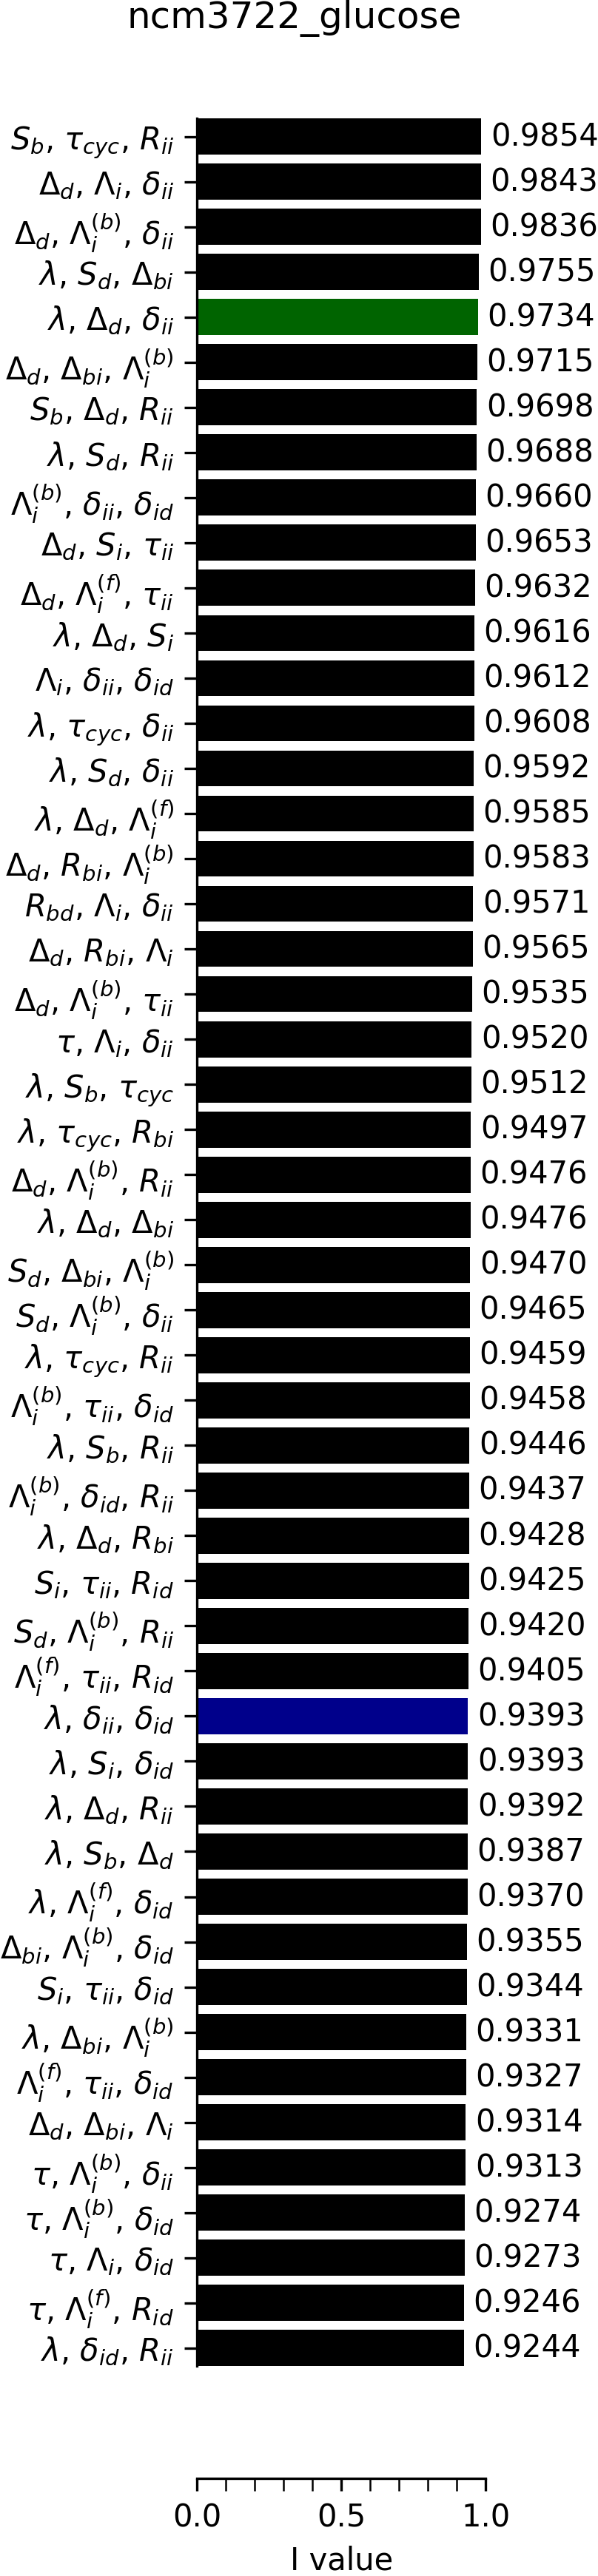

In [17]:
name = 'ncm3722_glucose'

# first figure
fname = "determinant_analysis_top{:d}".format(nval) + '.png'
fpath = os.path.join(direxp,name,fname)
# display one of the previous figures
Image(filename=fpath) 

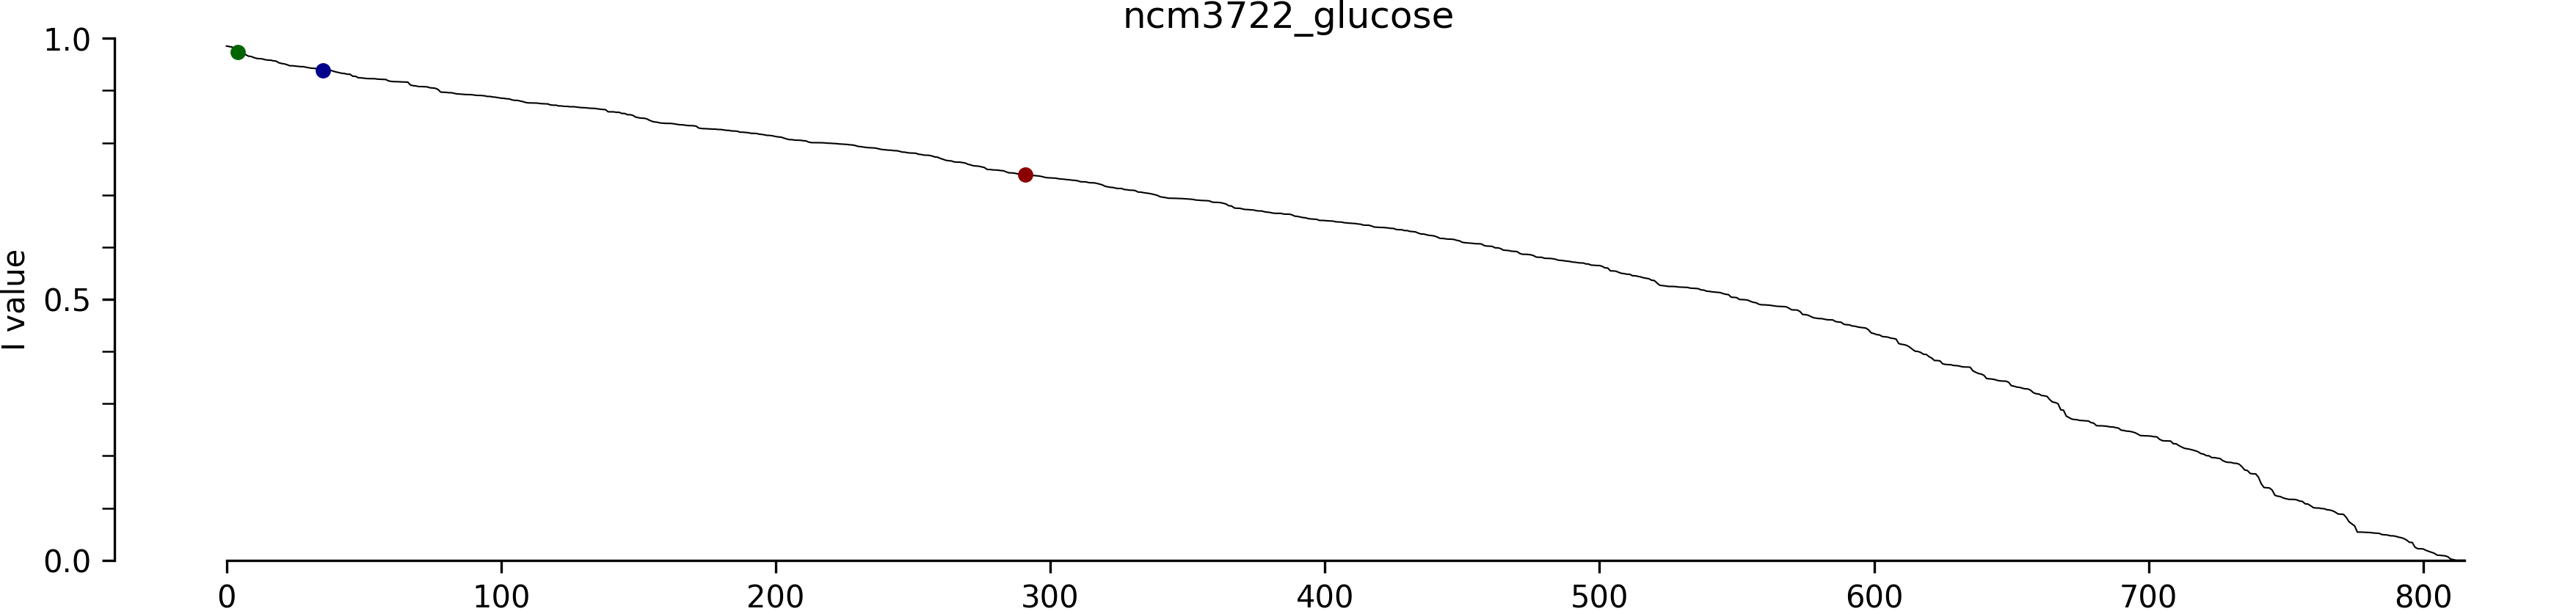

In [18]:
# second figure
fname = "determinant_analysis_all".format(nval) + '.png'
fpath = os.path.join(direxp,name,fname)
# display one of the previous figures
Image(filename=fpath) 

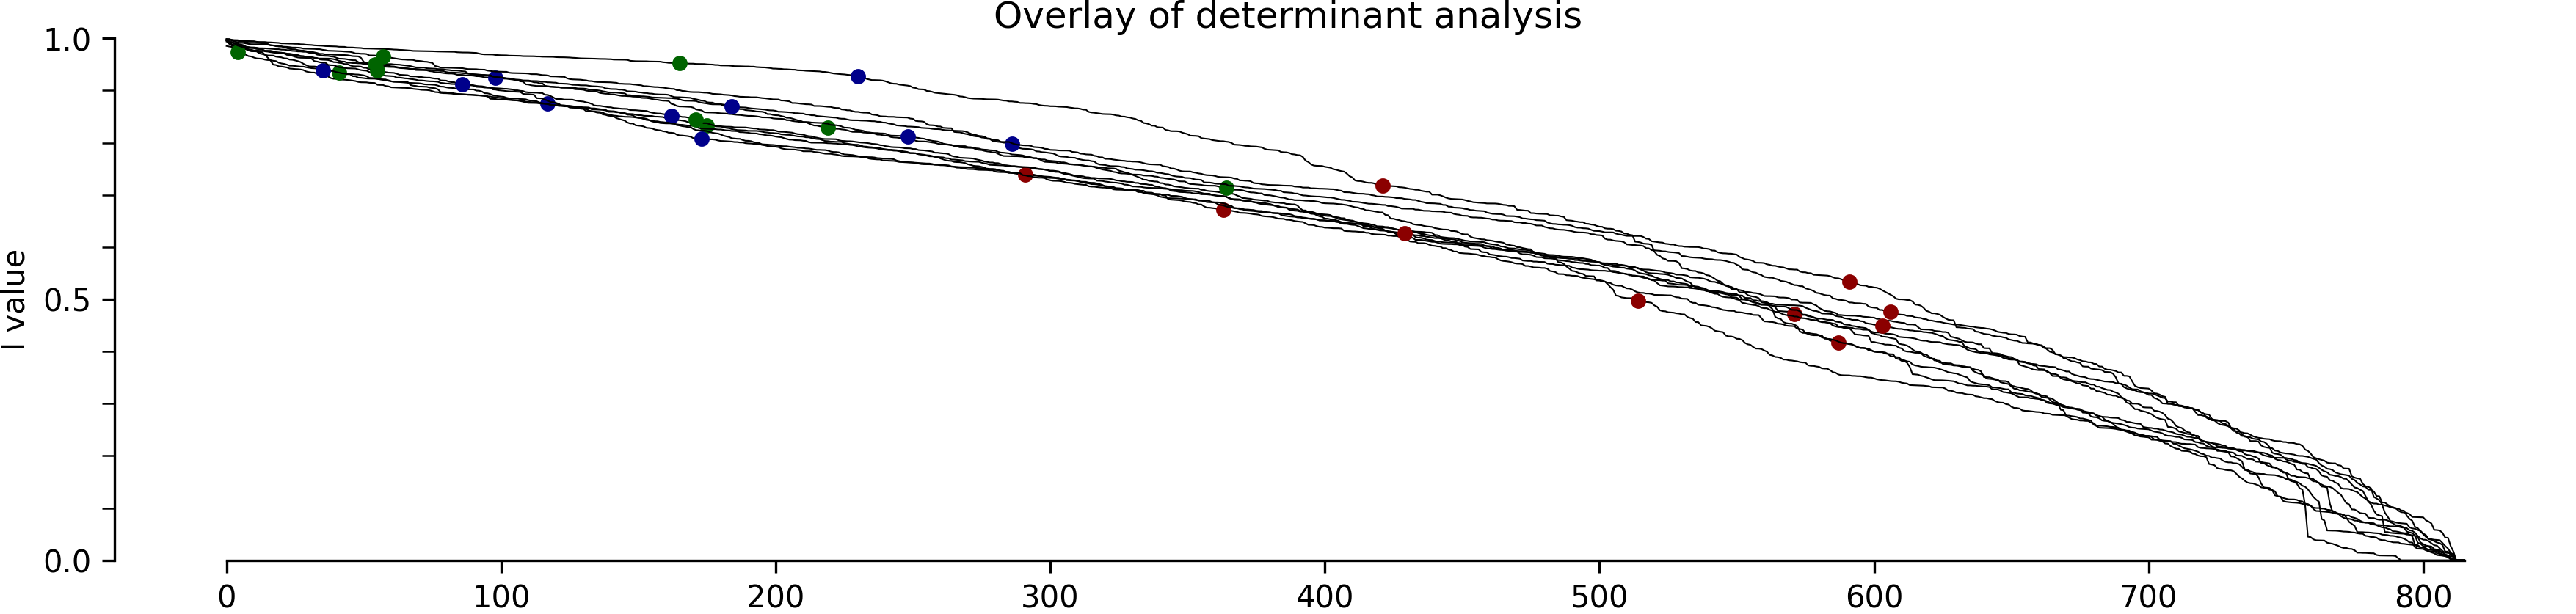

In [19]:
# second figure
fname = "determinant_analysis_overlay" + '.png'
fpath = os.path.join(direxp,fname)
# display one of the previous figures
Image(filename=fpath) 

## Overall score

In [20]:
scores = []
for comb in combinations:
    scores += [list(comb) + [None, None, None]]


In [21]:
for i in range(len(scores)):
    score = scores[i]
    comb = score[:3]
    
    ranks = []
    for name in names_all:
        fname = 'determinant_analysis'
        fpath = os.path.join(direxp,name,fname + '.txt')
        table = load_table(fpath)
        
        for j in range(len(table)):
            line = table[j]
            thiscomb = line[:3]
            
            if thiscomb == comb:
                ranks.append(j+1)
                break
        # end reading all file
    # end loop on conditions
    score[3] = np.sort(ranks)[int(len(ranks)/2)-1]
    score[4] = len(ranks)

medranks = [score[3] for score in scores]
values = np.sort(np.unique(medranks))
for score in scores:
    medrank = score[3]
    score[5] = values.tolist().index(medrank) + 1

scores.sort(key=lambda x: x[3])
headers=['var {:d}'.format(i+1) for i in range(nvar)]+['median rank', 'nexp', 'final rank']

fname = 'determinant_analysis_synthesis'
fpath = os.path.join(direxp,fname + '.txt')

with open(fpath,'w') as fout:
    fout.write(tabulate.tabulate(scores, tablefmt='plain', headers=headers))